<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/Working_Forecasting_Network_flows_from_Cloud_native_Edge_Boxes_using_Multivariate_Multi_step_Time_SeriesStacked_LSTM_sequence_to_sequence_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multivariate Multistep Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras 

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Downloading the dataset

In [27]:
#url='https://raw.kafka9092_Network-Flows_1.csvgithubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/'
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_1.csv'

df=pd.read_csv(url, sep=',', header=0, low_memory=False, infer_datetime_format=True, index_col=['Processing_time'], parse_dates=True)
df.head()

,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes
Processing_time,,,,,,,,,
2020-12-01 00:05:24.998000+09:00,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252
2020-12-01 00:10:44.861000+09:00,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435
2020-12-01 00:15:33.979000+09:00,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801
2020-12-01 00:25:41.464000+09:00,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254
2020-12-01 00:35:18.114000+09:00,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430


**Imputing Null values**

In [28]:
df = df.replace('?', np.nan)
df.isnull().sum()

min_tcp_window_size        0
max_tcp_window_size        0
avg_tcp_window_size        0
std_dev_tcp_window_size    0
min_data_bytes             0
max_data_bytes             0
avg_databytes              0
std_dev_databytes          0
total_data_bytes           0
dtype: int64

In [29]:
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]


#from sklearn.preprocessing import LabelEncoder
#for column in df.columns:
#    if df[column].dtype == type(object):
#        le = LabelEncoder()
#        df[column] = le.fit_transform(df[column])

df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

min_tcp_window_size        0
max_tcp_window_size        0
avg_tcp_window_size        0
std_dev_tcp_window_size    0
min_data_bytes             0
max_data_bytes             0
avg_databytes              0
std_dev_databytes          0
total_data_bytes           0
dtype: int64

Downsampling of Data from minutes to Days 

In [30]:
daily_df = df.resample('1H').sum()
#daily_df = df
daily_df.head()

,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes
Processing_time,,,,,,,,,
2020-12-01 00:00:00+09:00,21941.0,21951.0,21951.0,0.94,786.0,106755.0,20098.960938,19681.630859,7611554.0
2020-12-01 01:00:00+09:00,29249.0,29268.0,29268.0,1.52,842.0,147690.0,26204.730469,26742.371094,10279206.0
2020-12-01 02:00:00+09:00,26816.0,26829.0,26829.0,1.03,790.0,127395.0,24386.759766,24530.080078,9352916.0
2020-12-01 03:00:00+09:00,26817.0,26829.0,26829.0,1.01,834.0,124539.0,24384.160156,24481.349609,9347045.0
2020-12-01 04:00:00+09:00,29256.0,29268.0,29268.0,1.13,882.0,144260.0,25947.230469,26051.650391,9883890.0


In [31]:
daily_df.describe()

,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.00
mean,26271.232422,26287.058594,26282.089844,3.596070,872.956360,116522.257812,23869.136719,23240.828125,8638743.00
std,5198.701172,5187.164551,5196.750977,9.625584,108.052498,21899.902344,2780.807129,3145.495605,1393831.25
min,4688.000000,4721.000000,4692.000000,0.000000,197.000000,36993.000000,6272.860352,6210.410156,2328323.00
25%,26730.750000,26800.500000,26779.750000,0.300000,827.000000,100602.000000,22845.142578,21746.401855,7921705.50
50%,29252.000000,29268.000000,29268.000000,0.785000,885.000000,111941.500000,24065.929688,22896.160156,8128128.50
75%,29259.250000,29268.000000,29268.000000,1.130000,940.250000,139163.750000,26198.526855,26198.841797,10221167.50
max,29268.000000,29268.000000,29268.000000,96.869995,1205.000000,147971.000000,27978.419922,28264.599609,10376318.00


In [32]:
daily_df.shape, df.shape

((756, 9), (8576, 9))

In [33]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
#n_past = 25
#n_future = 5 
#n_past = 24
#n_future =1

# Hours or Days Unit
#n_past = 24 # Total hours = 8500+, 168 hours = 7 days

n_past = 12 
n_future = 6
#n_features =9

#n_past = 120
#n_future = 60
#n_past = 180
#n_future = 90

n_features =9

Train - Test Split

In [34]:

#train_df,test_df = daily_df[1:5574], daily_df[5574:]  # 65% and 35% Unit is No sampling
#train_df,test_df = daily_df[1:8000], daily_df[8000:]  # 65% and 35% Unit is 5 min
#train_df,test_df = daily_df[1:982], daily_df[982:]  # 75% and 25% Unit is 30 min
train_df,test_df = daily_df[1:491], daily_df[491:]  # 65% and 35% Unit is one Hour
#train_df,test_df = daily_df[1:567], daily_df[567:]  # 75% and 25% Unit is one Hour
#train_df,test_df = daily_df[1:80], daily_df[80:]  # 75% and 25% Unit is 6 Hours
#train_df,test_df = daily_df[1:40], daily_df[40:]  # 75% and 25% Unit is 12 Hours,(63, 9)
#train_df,test_df = daily_df[1:245], daily_df[245:]  # 75% and 25% Unit is 2 Hours,(63, 9)
#train_df,test_df = daily_df[1:20], daily_df[20:]  # 75% and 25% in days
train_df.shape,test_df.shape

((490, 9), (265, 9))

In [35]:
np.shape(train_df)


(490, 9)

In [36]:
np.shape(test_df)

(265, 9)

Scaling the values for faster training of the models.

In [37]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

**Converting the series to samples for supervised learning**

In [38]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [39]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [40]:
X_test.shape

(248, 12, 9)

**Model Architecture**

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers. 

In [41]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 12, 9)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 100), (None, 44000       input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 6, 100)       0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 6, 100)       80400       repeat_vector_2[0][0]            
                                                                 lstm_6[0][1]               

In [42]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12, 9)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 12, 100), (N 44000       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 100), (None, 80400       lstm_8[0][0]                     
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 6, 100)       0           lstm_9[0][0]                     
____________________________________________________________________________________________

In [43]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

 **Training the models**


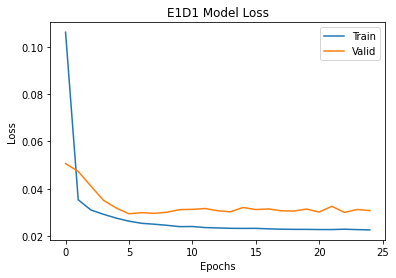

In [44]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [45]:
history_e1d1.history['loss'],history_e1d1.history['val_loss']

([0.1061423271894455,
  0.03538047522306442,
  0.03105805069208145,
  0.029246045276522636,
  0.027624869719147682,
  0.026350904256105423,
  0.025435956194996834,
  0.025061320513486862,
  0.024593820795416832,
  0.0240408293902874,
  0.024088401347398758,
  0.023645970970392227,
  0.023489007726311684,
  0.0233304426074028,
  0.02328919619321823,
  0.023309892043471336,
  0.023113517090678215,
  0.02295595407485962,
  0.02288932166993618,
  0.02287895418703556,
  0.022808773443102837,
  0.02280760183930397,
  0.022952860221266747,
  0.022777510806918144,
  0.022651756182312965],
 [0.050669021904468536,
  0.047358669340610504,
  0.041161250323057175,
  0.03512898087501526,
  0.031896159052848816,
  0.029473720118403435,
  0.029935322701931,
  0.02964100055396557,
  0.03012407012283802,
  0.03123573027551174,
  0.03132864087820053,
  0.031686048954725266,
  0.030759230256080627,
  0.030302876606583595,
  0.03212415799498558,
  0.031254012137651443,
  0.031508490443229675,
  0.030736967

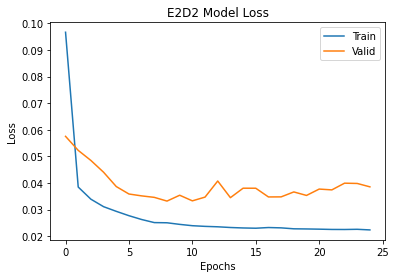

In [46]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Prediction on validation set

In [47]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

Inverse Scaling of the predicted values

In [48]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [49]:
#def mean_absolute_percentage_error(y_true, y_pred): 
        #y_true, y_pred = np.array(y_true), np.array(y_pred)
        #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    #print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    #print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    #print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

**Checking Error** 

Index(['min_tcp_window_size', 'max_tcp_window_size', 'avg_tcp_window_size',
       'std_dev_tcp_window_size', 'min_data_bytes', 'max_data_bytes',
       'avg_databytes', 'std_dev_databytes', 'total_data_bytes'],
      dtype='object')
min_tcp_window_size

Day  1 :
MAE-E1D1 :  2330.7424,     MAE-E2D2 :  2835.5483
MSE-E1D1 :  9703187.0, MSE-E2D2 :  12998592.0
RMSE-E1D1 :  3114.994,     NRMSE-E1D1 :  0.15790983,     RMSE-E2D2 :  3605.356
MAPE-E1D1 :  11.595302820205688,     MAPE-E1D1 :  13.665910065174103


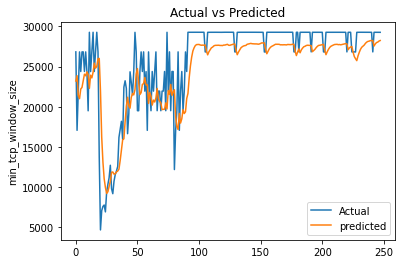

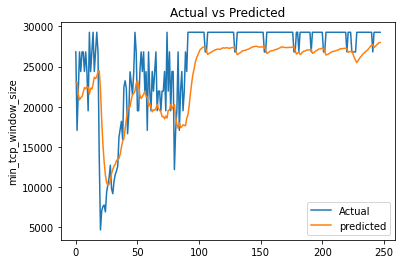


Day  2 :
MAE-E1D1 :  2535.1226,     MAE-E2D2 :  2846.9688
MSE-E1D1 :  11742632.0, MSE-E2D2 :  13863193.0
RMSE-E1D1 :  3426.7524,     NRMSE-E1D1 :  0.1636457,     RMSE-E2D2 :  3723.3308
MAPE-E1D1 :  13.023634254932404,     MAPE-E1D1 :  14.049090445041656


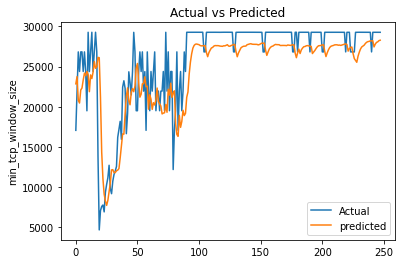

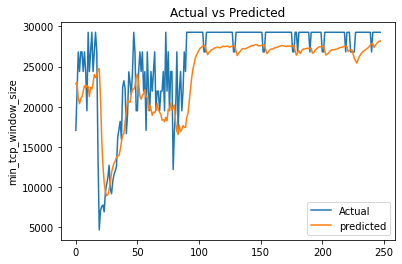


Day  3 :
MAE-E1D1 :  2781.0928,     MAE-E2D2 :  3081.136
MSE-E1D1 :  14069198.0, MSE-E2D2 :  16389000.0
RMSE-E1D1 :  3750.893,     NRMSE-E1D1 :  0.18062256,     RMSE-E2D2 :  4048.333
MAPE-E1D1 :  14.37796950340271,     MAPE-E1D1 :  15.173450112342834


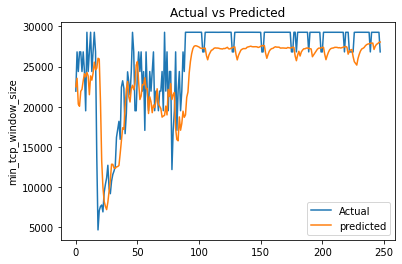

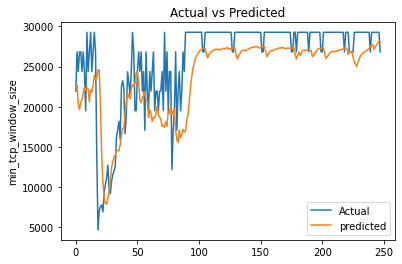


Day  4 :
MAE-E1D1 :  3043.268,     MAE-E2D2 :  3547.6013
MSE-E1D1 :  16745903.0, MSE-E2D2 :  20692700.0
RMSE-E1D1 :  4092.1758,     NRMSE-E1D1 :  0.20765923,     RMSE-E2D2 :  4548.923
MAPE-E1D1 :  15.699385106563568,     MAPE-E1D1 :  17.13346689939499


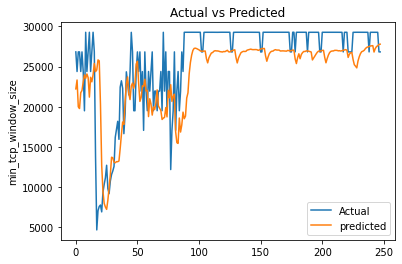

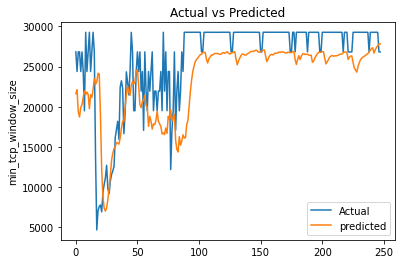


Day  5 :
MAE-E1D1 :  3355.3538,     MAE-E2D2 :  4220.282
MSE-E1D1 :  19323818.0, MSE-E2D2 :  26656806.0
RMSE-E1D1 :  4395.8867,     NRMSE-E1D1 :  0.2426867,     RMSE-E2D2 :  5163.023
MAPE-E1D1 :  17.28217899799347,     MAPE-E1D1 :  19.805234670639038


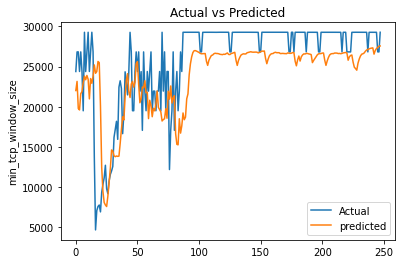

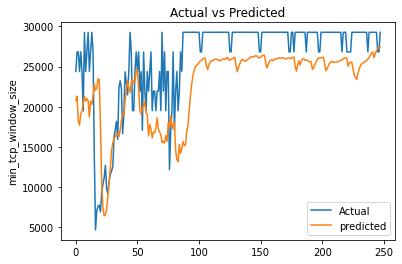



max_tcp_window_size

Day  1 :
MAE-E1D1 :  2190.027,     MAE-E2D2 :  2701.098
MSE-E1D1 :  8593503.0, MSE-E2D2 :  12030010.0
RMSE-E1D1 :  2931.4678,     NRMSE-E1D1 :  0.1508142,     RMSE-E2D2 :  3468.4304
MAPE-E1D1 :  11.102160066366196,     MAPE-E1D1 :  13.169112801551819


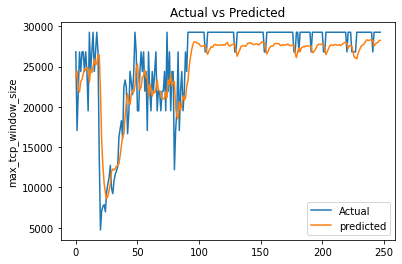

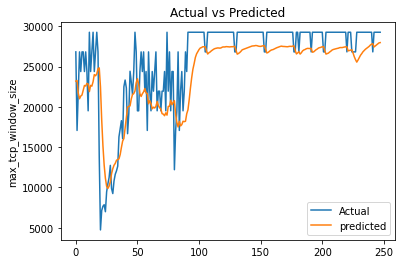


Day  2 :
MAE-E1D1 :  2518.887,     MAE-E2D2 :  2920.9077
MSE-E1D1 :  11234778.0, MSE-E2D2 :  14069126.0
RMSE-E1D1 :  3351.832,     NRMSE-E1D1 :  0.16539066,     RMSE-E2D2 :  3750.8833
MAPE-E1D1 :  12.917645275592804,     MAPE-E1D1 :  14.259685575962067


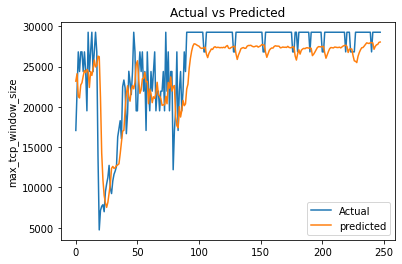

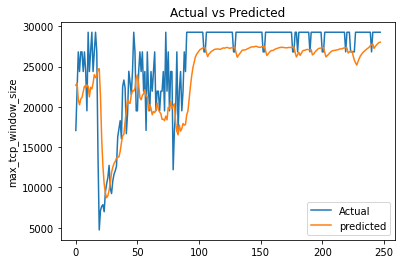


Day  3 :
MAE-E1D1 :  2798.171,     MAE-E2D2 :  3176.6472
MSE-E1D1 :  13709626.0, MSE-E2D2 :  16715182.0
RMSE-E1D1 :  3702.6511,     NRMSE-E1D1 :  0.18294564,     RMSE-E2D2 :  4088.4204
MAPE-E1D1 :  14.39409852027893,     MAPE-E1D1 :  15.449421107769012


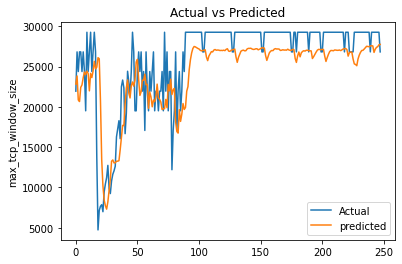

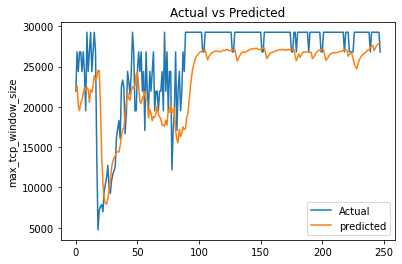


Day  4 :
MAE-E1D1 :  3033.5388,     MAE-E2D2 :  3577.804
MSE-E1D1 :  16213789.0, MSE-E2D2 :  20517186.0
RMSE-E1D1 :  4026.635,     NRMSE-E1D1 :  0.20619914,     RMSE-E2D2 :  4529.59
MAPE-E1D1 :  15.648263692855835,     MAPE-E1D1 :  17.180900275707245


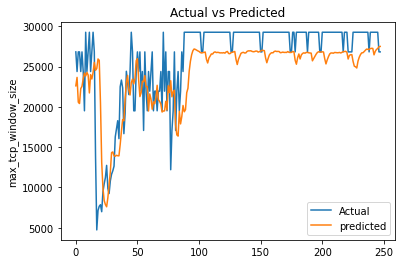

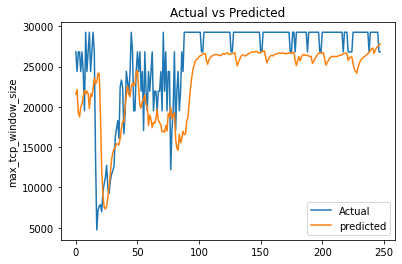


Day  5 :
MAE-E1D1 :  3286.5771,     MAE-E2D2 :  4127.787
MSE-E1D1 :  18442426.0, MSE-E2D2 :  25453452.0
RMSE-E1D1 :  4294.4644,     NRMSE-E1D1 :  0.23452461,     RMSE-E2D2 :  5045.1416
MAPE-E1D1 :  17.0205757021904,     MAPE-E1D1 :  19.421663880348206


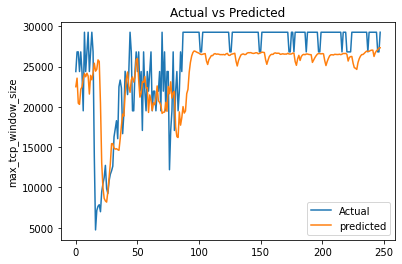

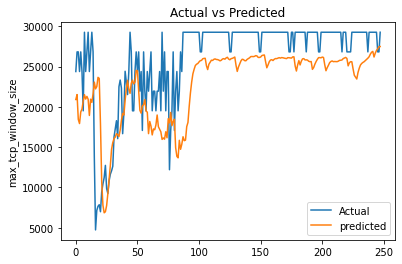



avg_tcp_window_size

Day  1 :
MAE-E1D1 :  2585.7559,     MAE-E2D2 :  2836.7615
MSE-E1D1 :  11821900.0, MSE-E2D2 :  13372807.0
RMSE-E1D1 :  3438.299,     NRMSE-E1D1 :  0.16244845,     RMSE-E2D2 :  3656.8848
MAPE-E1D1 :  12.890700995922089,     MAPE-E1D1 :  13.489280641078949


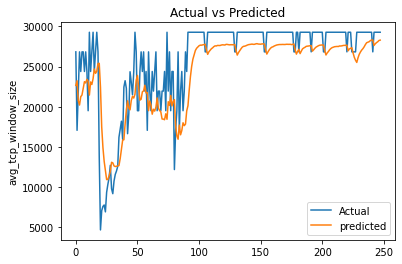

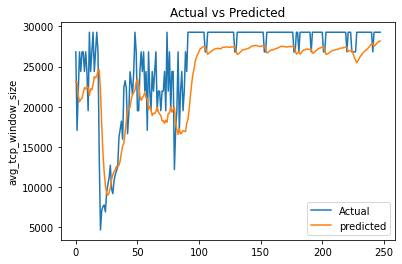


Day  2 :
MAE-E1D1 :  2588.9006,     MAE-E2D2 :  3040.251
MSE-E1D1 :  12424305.0, MSE-E2D2 :  15331580.0
RMSE-E1D1 :  3524.8127,     NRMSE-E1D1 :  0.17513993,     RMSE-E2D2 :  3915.5562
MAPE-E1D1 :  13.311855494976044,     MAPE-E1D1 :  14.677949249744415


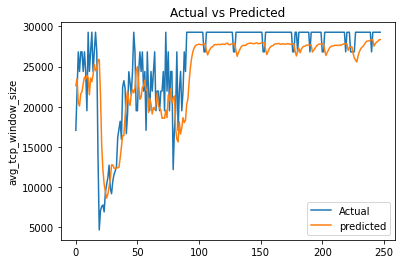

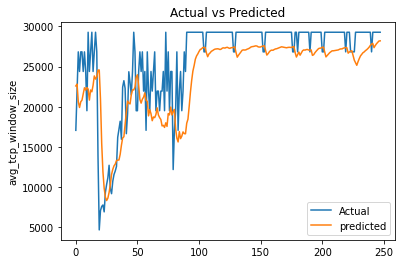


Day  3 :
MAE-E1D1 :  2751.8464,     MAE-E2D2 :  3308.883
MSE-E1D1 :  14170507.0, MSE-E2D2 :  18188748.0
RMSE-E1D1 :  3764.3733,     NRMSE-E1D1 :  0.19306825,     RMSE-E2D2 :  4264.8267
MAPE-E1D1 :  14.288832247257233,     MAPE-E1D1 :  15.94233363866806


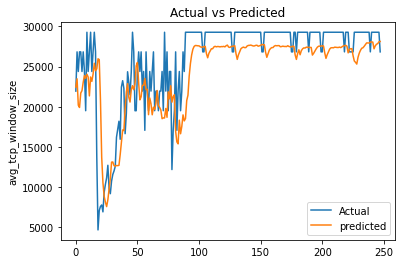

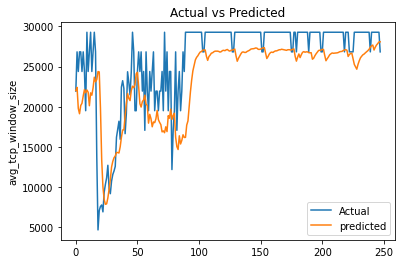


Day  4 :
MAE-E1D1 :  2988.794,     MAE-E2D2 :  3768.7046
MSE-E1D1 :  16565650.0, MSE-E2D2 :  22563624.0
RMSE-E1D1 :  4070.092,     NRMSE-E1D1 :  0.21900882,     RMSE-E2D2 :  4750.118
MAPE-E1D1 :  15.529970824718475,     MAPE-E1D1 :  17.870377004146576


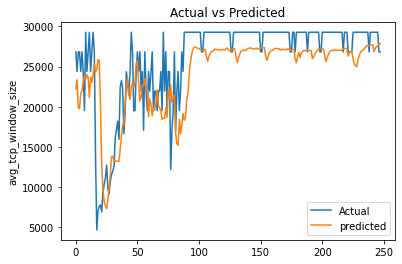

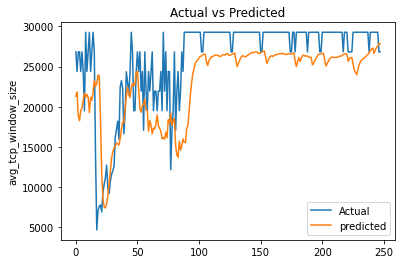


Day  5 :
MAE-E1D1 :  3286.3167,     MAE-E2D2 :  4410.874
MSE-E1D1 :  19025490.0, MSE-E2D2 :  28502868.0
RMSE-E1D1 :  4361.822,     NRMSE-E1D1 :  0.2523854,     RMSE-E2D2 :  5338.8076
MAPE-E1D1 :  17.05523580312729,     MAPE-E1D1 :  20.39027363061905


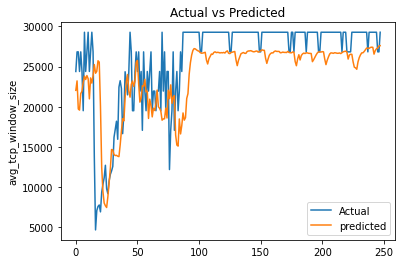

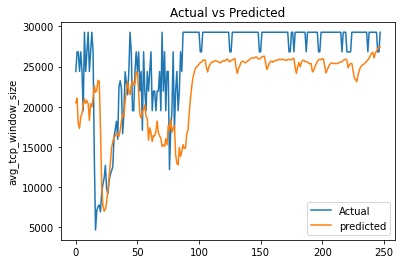



std_dev_tcp_window_size

Day  1 :
MAE-E1D1 :  5.310817,     MAE-E2D2 :  5.649062
MSE-E1D1 :  76.82224, MSE-E2D2 :  87.00405
RMSE-E1D1 :  8.76483,     NRMSE-E1D1 :  13.354064,     RMSE-E2D2 :  9.327597
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


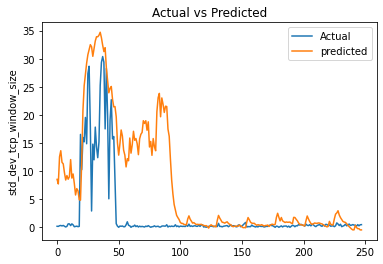

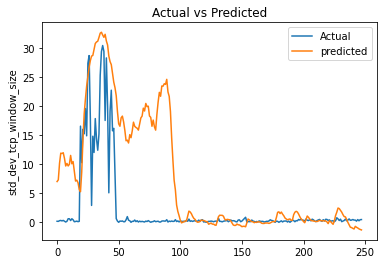


Day  2 :
MAE-E1D1 :  4.9060225,     MAE-E2D2 :  5.9409637
MSE-E1D1 :  62.551075, MSE-E2D2 :  89.30748
RMSE-E1D1 :  7.9089236,     NRMSE-E1D1 :  -1.6332299,     RMSE-E2D2 :  9.450263
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


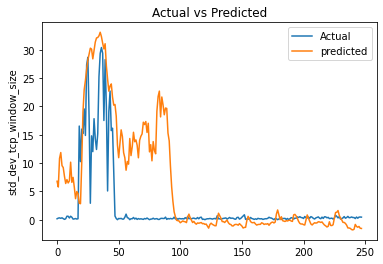

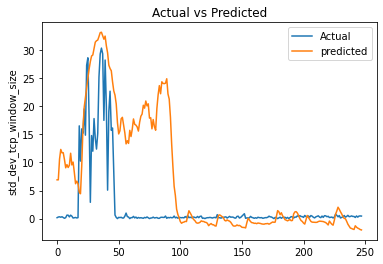


Day  3 :
MAE-E1D1 :  4.986207,     MAE-E2D2 :  6.2663755
MSE-E1D1 :  59.06541, MSE-E2D2 :  97.48714
RMSE-E1D1 :  7.6854024,     NRMSE-E1D1 :  -7.406519,     RMSE-E2D2 :  9.873557
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


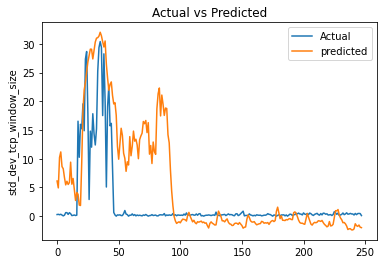

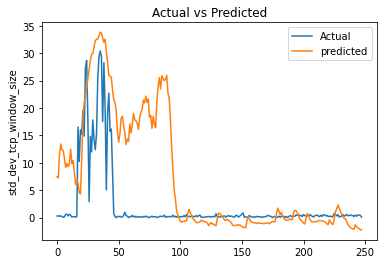


Day  4 :
MAE-E1D1 :  5.0746355,     MAE-E2D2 :  6.5100346
MSE-E1D1 :  59.946724, MSE-E2D2 :  109.41572
RMSE-E1D1 :  7.742527,     NRMSE-E1D1 :  -5.889808,     RMSE-E2D2 :  10.4601965
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


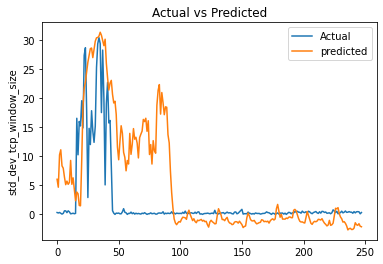

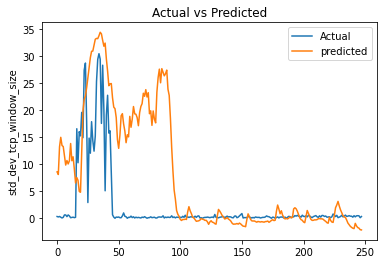


Day  5 :
MAE-E1D1 :  5.176084,     MAE-E2D2 :  6.8775377
MSE-E1D1 :  62.389538, MSE-E2D2 :  124.14095
RMSE-E1D1 :  7.898705,     NRMSE-E1D1 :  3.2010098,     RMSE-E2D2 :  11.141856
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


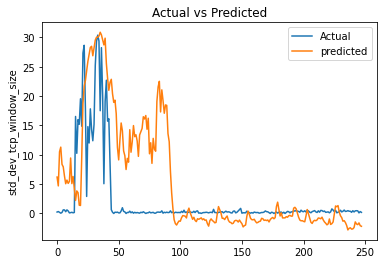

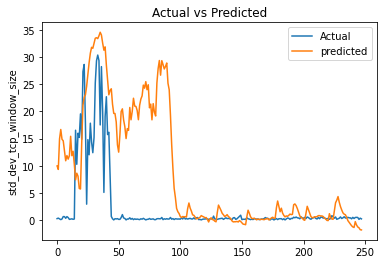



min_data_bytes

Day  1 :
MAE-E1D1 :  73.72316,     MAE-E2D2 :  76.90142
MSE-E1D1 :  9608.71, MSE-E2D2 :  9987.339
RMSE-E1D1 :  98.024025,     NRMSE-E1D1 :  0.12040217,     RMSE-E2D2 :  99.936676
MAPE-E1D1 :  9.58096757531166,     MAPE-E1D1 :  9.514357894659042


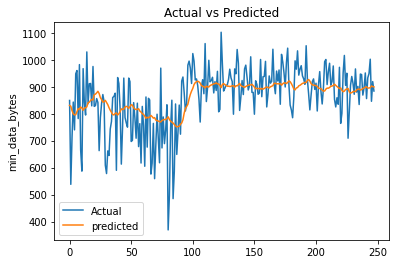

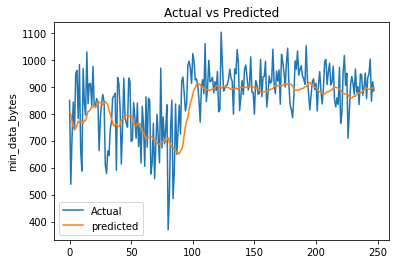


Day  2 :
MAE-E1D1 :  74.84514,     MAE-E2D2 :  76.07538
MSE-E1D1 :  9848.4795, MSE-E2D2 :  9891.373
RMSE-E1D1 :  99.2395,     NRMSE-E1D1 :  0.11861671,     RMSE-E2D2 :  99.45538
MAPE-E1D1 :  9.668944776058197,     MAPE-E1D1 :  9.511272609233856


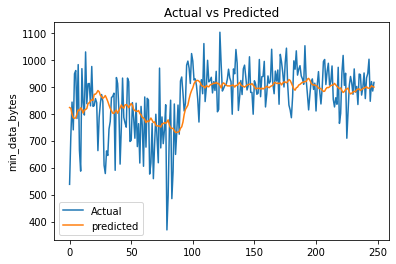

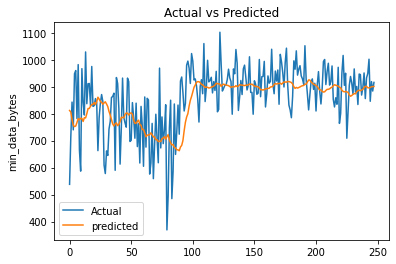


Day  3 :
MAE-E1D1 :  74.0986,     MAE-E2D2 :  74.68259
MSE-E1D1 :  9535.46, MSE-E2D2 :  9530.478
RMSE-E1D1 :  97.64968,     NRMSE-E1D1 :  0.11579421,     RMSE-E2D2 :  97.62417
MAPE-E1D1 :  9.457115828990936,     MAPE-E1D1 :  9.312157332897186


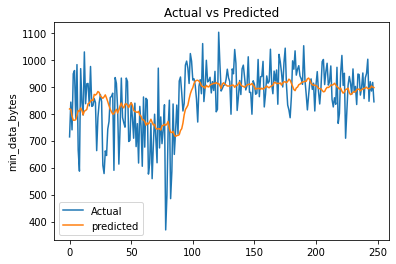

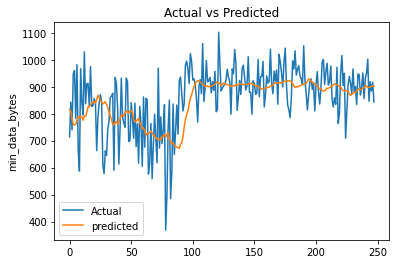


Day  4 :
MAE-E1D1 :  75.09358,     MAE-E2D2 :  75.30386
MSE-E1D1 :  9756.728, MSE-E2D2 :  9746.6455
RMSE-E1D1 :  98.776146,     NRMSE-E1D1 :  0.116812676,     RMSE-E2D2 :  98.7251
MAPE-E1D1 :  9.532764554023743,     MAPE-E1D1 :  9.412316232919693


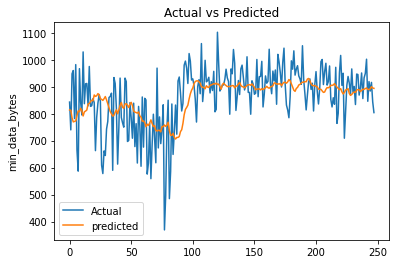

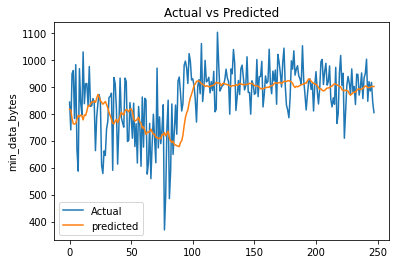


Day  5 :
MAE-E1D1 :  76.41643,     MAE-E2D2 :  76.26641
MSE-E1D1 :  9951.195, MSE-E2D2 :  9951.461
RMSE-E1D1 :  99.75568,     NRMSE-E1D1 :  0.117988415,     RMSE-E2D2 :  99.75701
MAPE-E1D1 :  9.661506861448288,     MAPE-E1D1 :  9.543856978416443


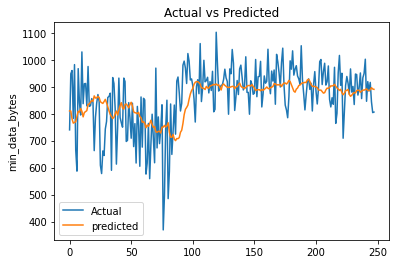

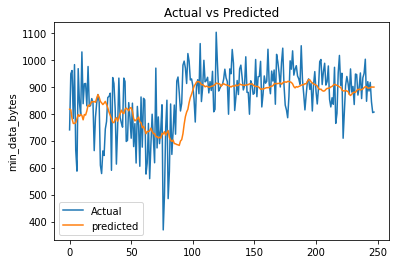



max_data_bytes

Day  1 :
MAE-E1D1 :  9864.378,     MAE-E2D2 :  8211.183
MSE-E1D1 :  199859180.0, MSE-E2D2 :  146132370.0
RMSE-E1D1 :  14137.156,     NRMSE-E1D1 :  0.11868666,     RMSE-E2D2 :  12088.522
MAPE-E1D1 :  12.429305911064148,     MAPE-E1D1 :  10.3458970785141


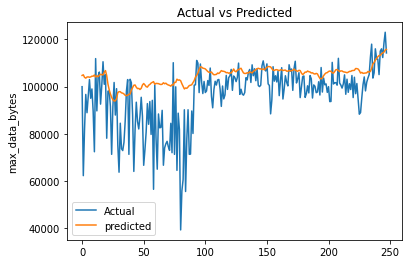

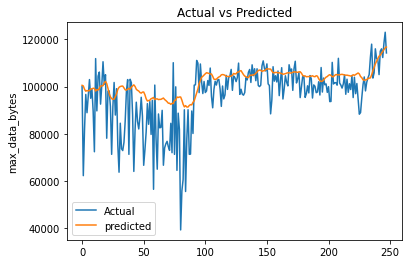


Day  2 :
MAE-E1D1 :  8843.397,     MAE-E2D2 :  7981.464
MSE-E1D1 :  175260400.0, MSE-E2D2 :  144350700.0
RMSE-E1D1 :  13238.595,     NRMSE-E1D1 :  0.11892905,     RMSE-E2D2 :  12014.604
MAPE-E1D1 :  11.262194067239761,     MAPE-E1D1 :  10.099286586046219


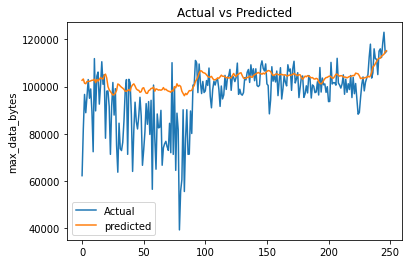

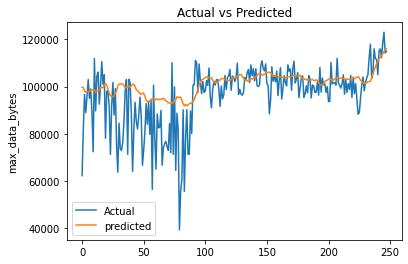


Day  3 :
MAE-E1D1 :  8397.635,     MAE-E2D2 :  8049.5654
MSE-E1D1 :  158324450.0, MSE-E2D2 :  145206420.0
RMSE-E1D1 :  12582.704,     NRMSE-E1D1 :  0.119218,     RMSE-E2D2 :  12050.162
MAPE-E1D1 :  10.615630447864532,     MAPE-E1D1 :  10.121805965900421


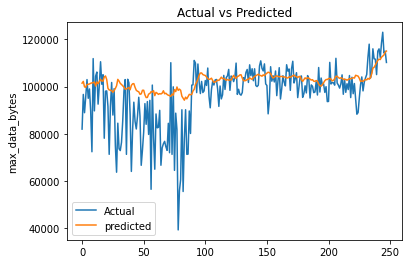

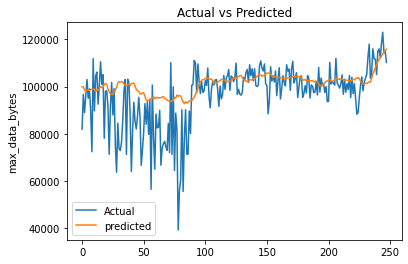


Day  4 :
MAE-E1D1 :  8224.172,     MAE-E2D2 :  8259.08
MSE-E1D1 :  151426130.0, MSE-E2D2 :  153339950.0
RMSE-E1D1 :  12305.532,     NRMSE-E1D1 :  0.12185941,     RMSE-E2D2 :  12383.051
MAPE-E1D1 :  10.357221215963364,     MAPE-E1D1 :  10.397674888372421


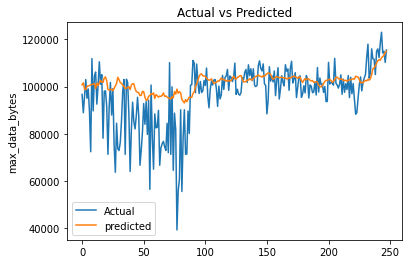

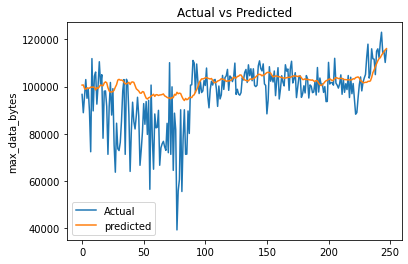


Day  5 :
MAE-E1D1 :  8211.813,     MAE-E2D2 :  8644.557
MSE-E1D1 :  150771090.0, MSE-E2D2 :  166299740.0
RMSE-E1D1 :  12278.888,     NRMSE-E1D1 :  0.12592886,     RMSE-E2D2 :  12895.726
MAPE-E1D1 :  10.285668075084686,     MAPE-E1D1 :  10.865440219640732


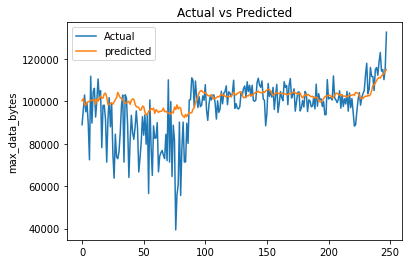

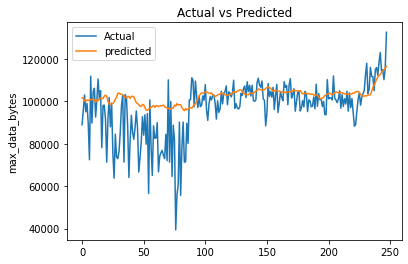



avg_databytes

Day  1 :
MAE-E1D1 :  1512.2687,     MAE-E2D2 :  1318.1971
MSE-E1D1 :  4043996.8, MSE-E2D2 :  4019733.5
RMSE-E1D1 :  2010.9691,     NRMSE-E1D1 :  0.09041201,     RMSE-E2D2 :  2004.9272
MAPE-E1D1 :  7.505160570144653,     MAPE-E1D1 :  6.889049708843231


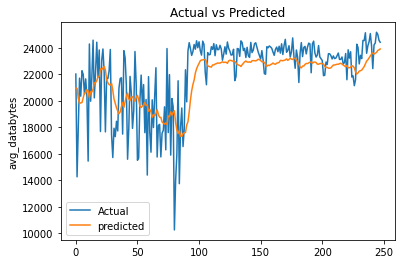

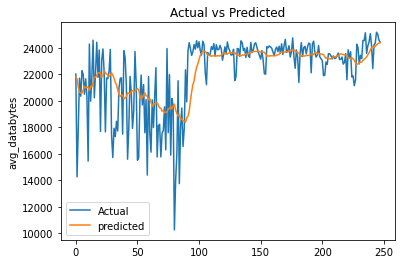


Day  2 :
MAE-E1D1 :  1444.5135,     MAE-E2D2 :  1385.3177
MSE-E1D1 :  4119905.0, MSE-E2D2 :  4208523.0
RMSE-E1D1 :  2029.7549,     NRMSE-E1D1 :  0.093217425,     RMSE-E2D2 :  2051.4685
MAPE-E1D1 :  7.3113106191158295,     MAPE-E1D1 :  7.1293458342552185


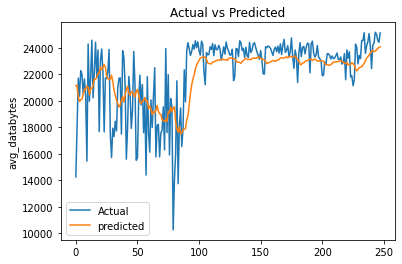

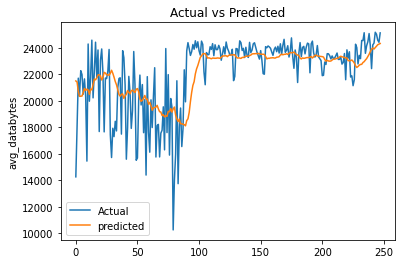


Day  3 :
MAE-E1D1 :  1423.2104,     MAE-E2D2 :  1463.0718
MSE-E1D1 :  4047480.5, MSE-E2D2 :  4232776.0
RMSE-E1D1 :  2011.8351,     NRMSE-E1D1 :  0.094202854,     RMSE-E2D2 :  2057.371
MAPE-E1D1 :  7.198058068752289,     MAPE-E1D1 :  7.34000951051712


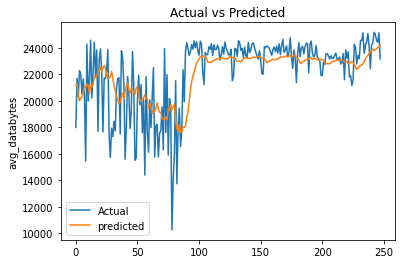

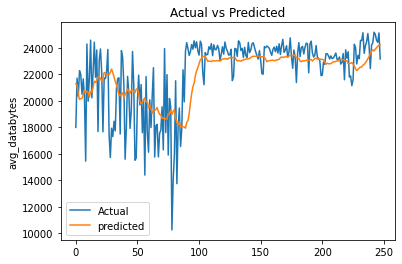


Day  4 :
MAE-E1D1 :  1439.733,     MAE-E2D2 :  1572.1184
MSE-E1D1 :  4191072.5, MSE-E2D2 :  4549377.0
RMSE-E1D1 :  2047.2109,     NRMSE-E1D1 :  0.09837925,     RMSE-E2D2 :  2132.9268
MAPE-E1D1 :  7.266203314065933,     MAPE-E1D1 :  7.759009301662445


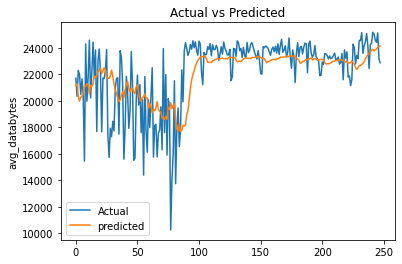

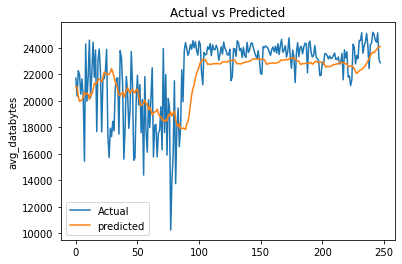


Day  5 :
MAE-E1D1 :  1478.4697,     MAE-E2D2 :  1698.0378
MSE-E1D1 :  4398275.5, MSE-E2D2 :  4963947.5
RMSE-E1D1 :  2097.2065,     NRMSE-E1D1 :  0.10345411,     RMSE-E2D2 :  2227.9917
MAPE-E1D1 :  7.4385859072208405,     MAPE-E1D1 :  8.277755975723267


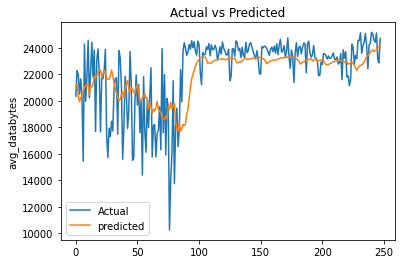

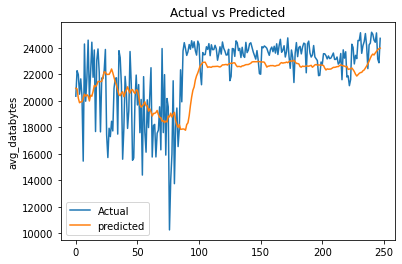



std_dev_databytes

Day  1 :
MAE-E1D1 :  1245.4062,     MAE-E2D2 :  1237.4099
MSE-E1D1 :  3788614.2, MSE-E2D2 :  3853111.8
RMSE-E1D1 :  1946.4363,     NRMSE-E1D1 :  0.09297671,     RMSE-E2D2 :  1962.9344
MAPE-E1D1 :  7.11456760764122,     MAPE-E1D1 :  7.060569524765015


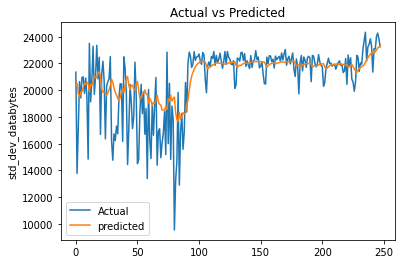

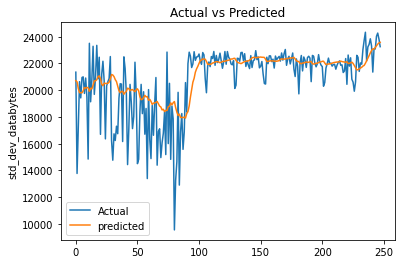


Day  2 :
MAE-E1D1 :  1308.603,     MAE-E2D2 :  1272.1897
MSE-E1D1 :  4424561.0, MSE-E2D2 :  4003661.5
RMSE-E1D1 :  2103.464,     NRMSE-E1D1 :  0.095035024,     RMSE-E2D2 :  2000.9152
MAPE-E1D1 :  7.585509866476059,     MAPE-E1D1 :  7.223199307918549


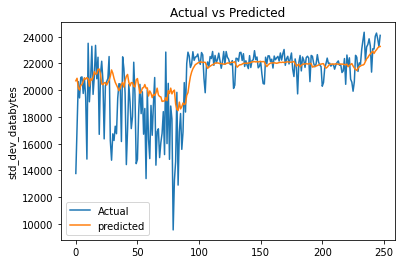

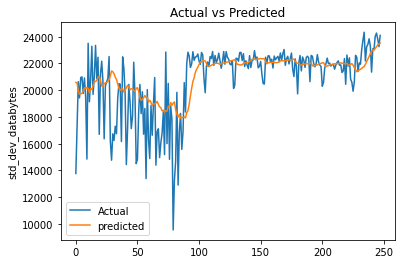


Day  3 :
MAE-E1D1 :  1357.407,     MAE-E2D2 :  1282.1674
MSE-E1D1 :  4762236.5, MSE-E2D2 :  4001420.5
RMSE-E1D1 :  2182.255,     NRMSE-E1D1 :  0.094874635,     RMSE-E2D2 :  2000.3551
MAPE-E1D1 :  7.860967516899109,     MAPE-E1D1 :  7.223892956972122


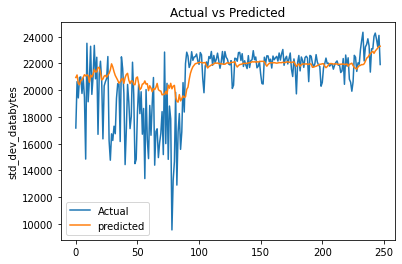

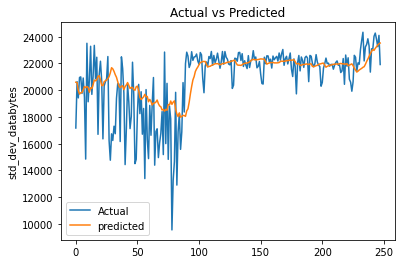


Day  4 :
MAE-E1D1 :  1431.2119,     MAE-E2D2 :  1313.9789
MSE-E1D1 :  5162140.5, MSE-E2D2 :  4173695.8
RMSE-E1D1 :  2272.0344,     NRMSE-E1D1 :  0.09671047,     RMSE-E2D2 :  2042.9625
MAPE-E1D1 :  8.271795511245728,     MAPE-E1D1 :  7.3897771537303925


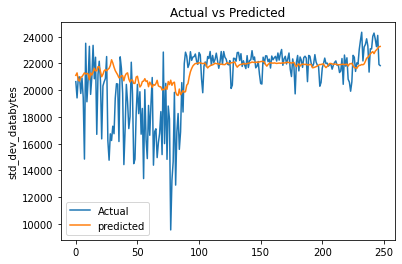

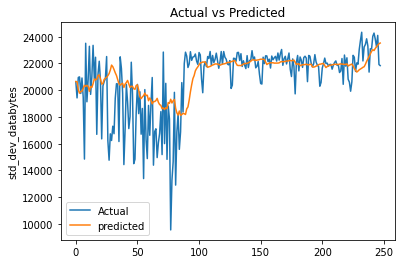


Day  5 :
MAE-E1D1 :  1481.3677,     MAE-E2D2 :  1360.4493
MSE-E1D1 :  5541909.5, MSE-E2D2 :  4391248.5
RMSE-E1D1 :  2354.126,     NRMSE-E1D1 :  0.09909802,     RMSE-E2D2 :  2095.5305
MAPE-E1D1 :  8.569318801164627,     MAPE-E1D1 :  7.641037553548813


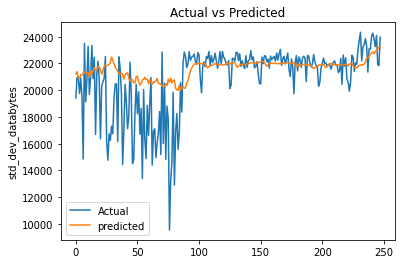

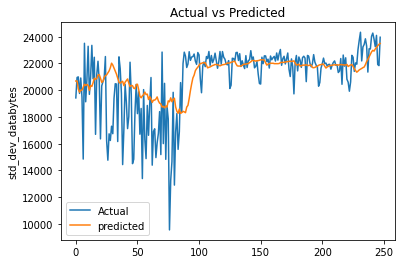



total_data_bytes

Day  1 :
MAE-E1D1 :  466825.34,     MAE-E2D2 :  518128.62
MSE-E1D1 :  560533100000.0, MSE-E2D2 :  479626230000.0
RMSE-E1D1 :  748687.56,     NRMSE-E1D1 :  0.093983814,     RMSE-E2D2 :  692550.5
MAPE-E1D1 :  7.597264647483826,     MAPE-E1D1 :  7.789736241102219


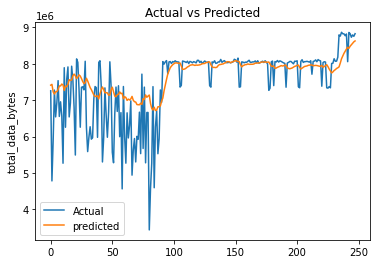

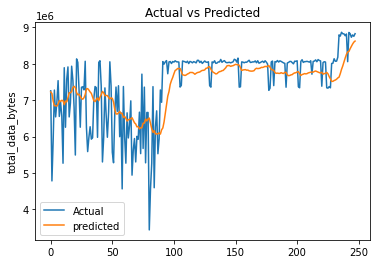


Day  2 :
MAE-E1D1 :  519398.7,     MAE-E2D2 :  542184.06
MSE-E1D1 :  567116800000.0, MSE-E2D2 :  513393920000.0
RMSE-E1D1 :  753071.56,     NRMSE-E1D1 :  0.096903495,     RMSE-E2D2 :  716515.1
MAPE-E1D1 :  8.200009912252426,     MAPE-E1D1 :  8.15759226679802


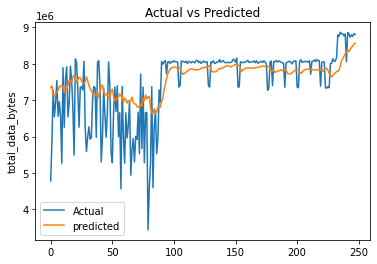

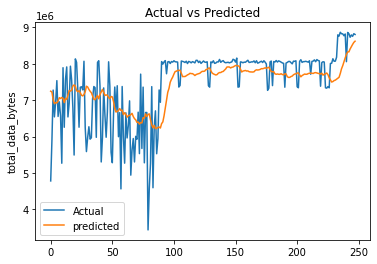


Day  3 :
MAE-E1D1 :  534479.7,     MAE-E2D2 :  551418.2
MSE-E1D1 :  551840840000.0, MSE-E2D2 :  519237240000.0
RMSE-E1D1 :  742859.94,     NRMSE-E1D1 :  0.097190164,     RMSE-E2D2 :  720581.2
MAPE-E1D1 :  8.277373015880585,     MAPE-E1D1 :  8.242179453372955


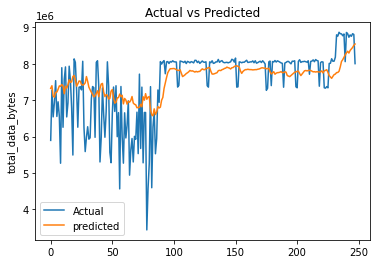

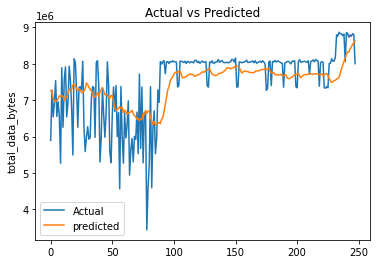


Day  4 :
MAE-E1D1 :  542795.5,     MAE-E2D2 :  564544.25
MSE-E1D1 :  557724470000.0, MSE-E2D2 :  542408770000.0
RMSE-E1D1 :  746809.5,     NRMSE-E1D1 :  0.09912071,     RMSE-E2D2 :  736484.06
MAPE-E1D1 :  8.350318670272827,     MAPE-E1D1 :  8.426738530397415


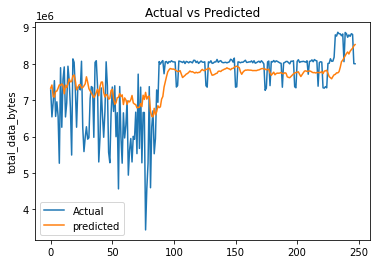

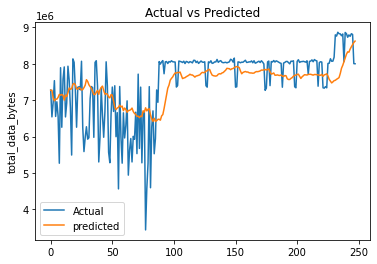


Day  5 :
MAE-E1D1 :  560136.0,     MAE-E2D2 :  585119.9
MSE-E1D1 :  582566600000.0, MSE-E2D2 :  574687940000.0
RMSE-E1D1 :  763260.5,     NRMSE-E1D1 :  0.10184892,     RMSE-E2D2 :  758081.75
MAPE-E1D1 :  8.58718529343605,     MAPE-E1D1 :  8.727782964706421


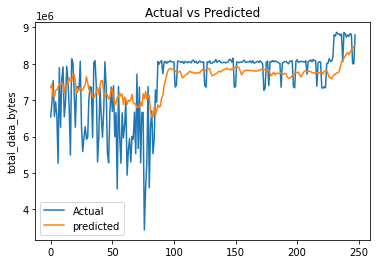

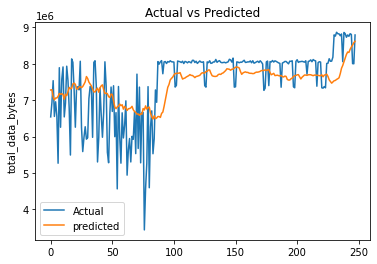

In [50]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from plotnine import ggplot, aes, geom_line
import matplotlib.pyplot as plt



def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#for index,i in enumerate(train_df.columns):
print(train_df.columns)
for index,i in enumerate(train_df.columns):
  print(i)
  
  for j in range(1,6):
  
   
    print()
    print("Day ",j,":")
   #print("Test-E1D1 : ",y_test[:,j-1,index])
    #print("Pred-E1D1 : ",pred1_e1d1[:,j-1,index])
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=",     ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    RMSE=np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))

     
    
    print("MSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    print("RMSE-E1D1 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index])),end=",     ")
    print("NRMSE-E1D1 : ", np.mean(np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))/pred1_e2d2[:,j-1,index]),end=",     ")
    #(np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 10
    #(np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100 
    print("RMSE-E2D2 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index])))
    #print("RMSPE-E1D1 : ",(np.sqrt(np.mean(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]))/y_test[:,j-1,index]))*100,end=",     ")
    #print("RMSPE-E2D2 : ",(np.sqrt(np.mean(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))/y_test[:,j-1,index]))*100)
    
    print("MAPE-E1D1 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=",     ")
    print("MAPE-E1D1 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))

   
   
                   

   
    
    plt.plot( list(y_test[:,j-1,index]),)
    plt.plot( list(pred1_e1d1[:,j-1,index]))
    
    
    #plt.plot( list(pred1_e1d1[:,j-1,index]),kind='line', marker='d')
    
    #plt.bar(list(y_test[:,j-1,index] - list(pred1_e1d1[:,j-1,index])),10,2.5)
    #ax = plt.gca()
    #plt.xlim([y_test[:,j-1,index], list(pred1_e1d1[:,j-1,index]))
    
    #df = pd.DataFrame({'a': [100, 200, 150, 175],
    #               'b': [430, 30, 20, 10]})
    
    #df['b'].plot(kind='bar', color='y')
    #df['a'].plot(kind='line', marker='d')

    plt.title("Actual vs Predicted")
    plt.ylabel(i)
    plt.legend(('Actual','predicted'))
    
    
    plt.show()

    

    plt.plot( list(y_test[:,j-1,index]))
    plt.plot( list(pred1_e2d2[:,j-1,index]))
    
    plt.title("Actual vs Predicted")
    plt.ylabel(i)
    plt.legend(('Actual','predicted'))
    plt.show()
  print()
  print()
  

From the above output we can observe that in some cases E2D2 model has 
performed better than E1D1 model with less error. Training different models with different number of stacked layers and creating an ensemble model also performs well. 

Note: The results vary with respect to the dataset. If we stack more layers it may also lead to overfitting. So the no of layers to be stackes acts as a hyper parameter. 